In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Dropout, Flatten, Lambda
from keras.optimizers import Adam
from keras.models import Sequential
import matplotlib.pylab as plt
%matplotlib inline

Using Theano backend.


In [2]:
import numpy as np
import keras
batch_size = 64
num_classes = 2
num_epoch = 10

Copy cats and dogs images from the train set into the format for keras (one folder for each class)

In [3]:
# import glob
# import shutil
# import os
# dst_cats = "./train_keras_format/cats/"
# dst_dogs = "./train_keras_format/dogs/"
# src = "./train/train/"
# for f in glob.glob("./train/train/cat.*"):
#     shutil.copy(f, os.path.join(dst_cats))
    
# for f in glob.glob("./train/train/dog.*"):
#     shutil.copy(f, os.path.join(dst_dogs))

Move some files to create a validation set (Also, copy some files from train set to create a sample set ... done through windows directly)

In [4]:
# valid_cats_dst = "./validation_keras_format/cats/"
# valid_dogs_dst = "./validation_keras_format/dogs/"

# cats_shuf = np.random.permutation(glob.glob(dst_cats + "*.jpg"))
# dogs_shuf = np.random.permutation(glob.glob(dst_dogs + "*.jpg"))


# for i in range(0,1000):
#     shutil.move(cats_shuf[i], valid_cats_dst)
#     shutil.move(dogs_shuf[i], valid_dogs_dst)

Get generator object to generate batches using keras from train and validation 

Function to use keras generator to generate batches from the path directly (See Keras documentation: https://keras.io/preprocessing/image/)

In [5]:
path = "data/dogscats/sample/"

In [6]:
def get_batches(path, gen=ImageDataGenerator(), shuffle=True, batch_size=8, class_mode="categorical"):
    return gen.flow_from_directory(directory=path, target_size=(224,224), batch_size=batch_size, 
                                   class_mode=class_mode)

Let us look at some images that come out of the batches 

In [7]:
temp_batch_size = 4
# temp_train_batches = get_batches("./train_keras_format/", batch_size=temp_batch_size)
temp_train_batches = get_batches(path+'train', batch_size=temp_batch_size)

Found 160 images belonging to 2 classes.


In [8]:
temp_img , temp_label = next(temp_train_batches)

In [9]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

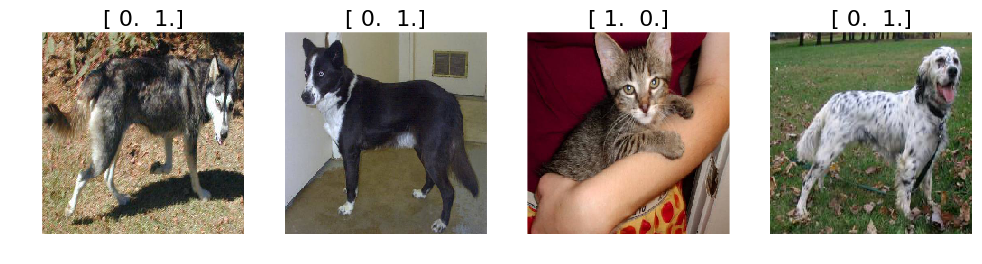

In [10]:
plots(temp_img, titles=temp_label)

In [11]:
train_batch = get_batches(path+'train', batch_size=batch_size)
valid_batch = get_batches(path+'valid', batch_size=batch_size)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Define the model

* Filter size = 3 with stride 1 => pad with 1
* Filter size = 5 with stride 1 => pad with 2
* Filter size = 7 with stride 1 => pad with 3

Source : https://youtu.be/GYGYnspV230?t=1086


Output size = (N-F)/stride + 1

In [12]:
#filter of size 3 with padding of 1, stride 1
#max pooling of 2 by 2, stride of 2
#kernel size 3 by 3
#activation relu
def add_conv_block(model, num_of_layers, num_of_filters, activ='relu'):
    for i in range(num_of_layers):
        model.add(ZeroPadding2D(padding=(1,1)))
        model.add(Convolution2D(num_of_filters, 3,3, activation=activ))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    return model

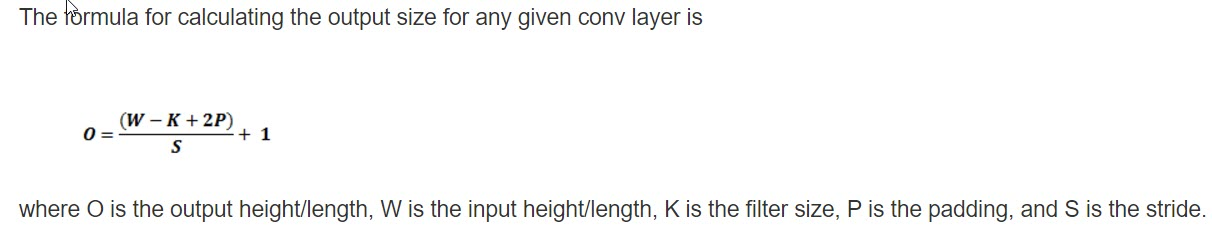

In [13]:
from IPython.display import Image
Image(filename='RelationBetweenOutputAndInputForConvLayers.jpg')

In [14]:
def add_dense_block(model, size, activ):
    model.add(Dense(size, activation=activ))
    return model

In [15]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    #normalize
    x = x - vgg_mean
    #convert from rgb to bgr , since that was used originally in vgg architecture
    return x[:, ::-1]

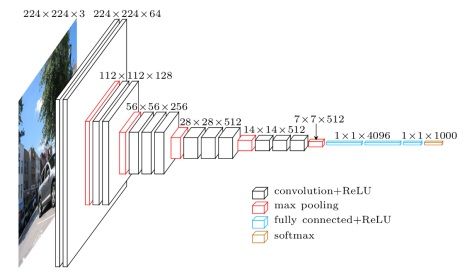

In [16]:
Image(filename='vgg16.jpg')

In [17]:
def VGG16():
    model = Sequential()
    
    #preprocess image - center around mean, convert to bgr from rgb
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
    model = add_conv_block(model, 2, 64 , activ='relu')
    model = add_conv_block(model, 2, 128, activ='relu')
    model = add_conv_block(model, 3, 256, activ='relu')
    model = add_conv_block(model, 3, 512, activ='relu')
    model = add_conv_block(model, 3, 512, activ='relu')
    
    model.add(Flatten())
    
    model = add_dense_block(model, 4096, 'relu')
    model.add(Dropout(0.5))
    model = add_dense_block(model, 4096, 'relu')
    model.add(Dropout(0.5))    
    model = add_dense_block(model, 1000, 'softmax')
    return model

In [18]:
vgg16 = VGG16()   

In [19]:
vgg16.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

Load weights from the original pretrained model

In [21]:
from keras.utils.data_utils import get_file
FILES_PATH = 'http://files.fast.ai/models/'
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
vgg16.load_weights(fpath)

Let us now update the model such that we take the last layer out and retrain the last layer only with the two new classes

In [22]:
#remove the last layer
vgg16.pop()

#Make the rest of the layers non-trainable
for layer in vgg16.layers:
    layer.trainable = False

#add a dense layer
vgg16 = add_dense_block(vgg16, num_classes, 'softmax')

In [23]:
vgg16.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

Fit model to batches

In [24]:
vgg16.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
vgg16.fit_generator(train_batch, samples_per_epoch=train_batch.nb_sample, 
                    nb_epoch=num_epoch, 
                    validation_data=valid_batch, nb_val_samples=valid_batch.nb_sample)

Epoch 1/10


KeyboardInterrupt: 

Save model

In [26]:
model_path = "./Model"

In [27]:
vgg16.save_weights(model_path+'finetune1.h5')

In [28]:
vgg16.load_weights(model_path+'finetune1.h5')

In [ ]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [ ]:
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [ ]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [ ]:
# val_data = get_data(path+'valid')
# val_classes = valid_batch.classes

In [ ]:
#vgg16.evaluate(val_data, val_labels)

Predict on test 

In [ ]:
# preds = vgg16.predict_classes(val_data, batch_size=batch_size)
# probs = vgg16.predict_proba(val_data, batch_size=batch_size)[:,0]
# probs[:8]

In [ ]:
# cm = confusion_matrix(val_classes, preds)

In [ ]:
# plot_confusion_matrix(cm, {'cat':0, 'dog':1})